# Chapter 3 – Fiction: Growing Down in the Novels of Maria Edgeworth and Amelia Opie

According to most scholars, the *Bildungsroman* is the central genre of Romantic fiction. The *Bildungsroman*, at least in its ‘classical’ or Romantic form, is the novel of successful self-formation. The protagonist of the Bildungsroman goes out in the world, develops their personality, and finally settles down. Scholars have constructed a canon around a core of optimistic novels—*Wilhelm Meister’s Apprenticeship* (1795-96), *Pride and Prejudice* (1813), *Waverley* (1814)—whose protagonists successfully go out into the world and find a place within it. In such *Bildungsromane*, the protagonist is both free and constrained. They pursue their inclinations while fulfilling their duties. They express their individuality while conforming to the social order. They achieve a ‘balance of harmony with freedom’, as Karl Morgenstern put it in a classic essay from 1820.

In this Chapter, I consider two novels that contradict the concept of the *Bildungsroman*. In Amelia Opie’s *Adeline Mowbray* (1804) and Maria Edgeworth’s *Vivian* (1812), there is no balance between individuality and the social order, between freedom and harmony, between autonomy and authority. To show that these novels were not mere outliers in the period, I analyse them as part of a corpus of 40 novels from the period, including a mixture of classic *Bildungsromane* such as *Camilla* (1796), *Marriage* (1818) and *The Old Manor House* (1793), American network novels such as *Arthur Mervyn* (1799), *The Coquette* (1797) and *Hobomok* (1824), as well as a number of Gothic, Jacobin, Anti-Jacobin, Historical and National Novels. The [files](data/novel-corpus/) and [metadata](data/novel-corpus/manifest.json) can be found in this repository, with the exception of 5 files, identified in the metadata, which are under copyright.

In this Notebook, I generate the tables and figures that can be found in Chapter 3 of *Contingent Selves: Romanticism and the Challenge of Representation*.

In [1]:
from collections import Counter
from itertools import zip_longest, chain
import re

from romanticself import *
from nltk import wordpunct_tokenize, word_tokenize, pos_tag
from nltk.corpus import stopwords
from tqdm.notebook import tqdm

import pandas as pd
import numpy as np
import igraph as ig
import nltk

In [ ]:
# For tokenizers
nltk.download('punkt')
nltk.download('tagsets')

In [78]:
corpus = NovelCorpus("data/novel-corpus", tokenizer=word_tokenize)

40 novels imported from data/novel-corpus.


## 3.1: Character: Unnecessary Beings

### Figure 3.1 Self-control was a central theme in Romantic fiction

In [ ]:
def count_compound_words(corpus, stem, relative=True):
    """Count relative frequencies of words beginning with given stem in corpus.
    
    Arguments:
    - corpus (iterable): iterable of tokenised texts
    - stem (str): words must begin with this stem to be counted
    - relative (bool): divide frequencies by word length of each text?"""

    compound_words = []

    for novel in tqdm(corpus, total=len(corpus)):
        counts = Counter()
        for word in novel:
            if word.startswith(stem):
                counts[word] += 1

        if relative == True:
            wc = len(novel)
            counts = {word:(count/wc * 1000) for word,count in counts.items()}

        compound_words.append(counts)
    
    data_frame = pd.DataFrame.from_dict(compound_words)
    data_frame["title"] = [title[0] for title in corpus.yield_metadata("short_title")]
    data_frame.set_index("title", inplace=True)
    data_frame.fillna(0, inplace=True)

    return data_frame

In [ ]:
self_compounds = count_compound_words(corpus, stem="self-")

In [ ]:
def compound_words_output(compound_words, topn=20, tocsv=False, novels=list()):
    """Extracts readable output of compound_words function.
    
    Arguments:
    - compound_words (pd.DataFrame): output of count_compound_words
    - topn (int): maximum number of words to show in table
    - tocsv (str): csv to save results to. Pass False to avoid
    - novels (iterable): titles of the novels to be included in output"""

    results = dict()
    
    # Results for each novel
    for novel in novels:
        # Get frequencies for that novel
        novel_result = compound_words.loc[novel].sort_values(ascending=False)
        # Filter out compounds that don't appear
        novel_result = novel_result[novel_result > 0]
        # Convert to list and append
        results[novel] = list(zip(novel_result.index, novel_result))

    # Corpus statistics
    corpus_means = compound_words.mean().sort_values(ascending=False)[:topn]
    results["Corpus"] = list(zip(corpus_means.index,corpus_means))
    
    # Save to csv
    if tocsv:
        with open(tocsv, "wt") as file:
            first_row = ",values,".join(results) + ",values\n"
            file.write(first_row)
            for row in zip_longest(*results.values(), fillvalue=","):
                row_str = ",".join(str(val) for val in chain(*row)) + "\n"
                file.write(row_str)

    return results

In [ ]:
figure_3_1_data = compound_words_output(compound_words=self_compounds, topn=20, tocsv="figures/figure_3_1.csv", 
                                        novels=["Vivian", "Adeline Mowbray"])

In [ ]:
figure_3_1_data["Vivian"]

In [ ]:
figure_3_1_data["Adeline Mowbray"]

In [ ]:
figure_3_1_data["Corpus"]

In [ ]:
# How many novels use the term 'self-denial'?
self_compounds.astype(bool).sum(axis=0).sort_values(ascending=False)[:20]

### Figure 3.2 *Vivian* and *Adeline Mowbray* are particularly focussed on the self

In [ ]:
per_novel_totals = self_compounds.sum(axis=1).sort_values(ascending=False)
# Export csv for Figure 3.2
per_novel_totals.to_csv("figures/figure_3_2.csv")
# And print the data to the screen
per_novel_totals

In [ ]:
# What is the average use of 'self-' compounds across the corpus?
per_novel_totals.mean()

In [ ]:
# Do network novels use 'self-' compounds much?
network = [net[0] for net in corpus.yield_metadata("network")]

network_mean = self_compounds.sum(axis=1)[network].mean()
non_network_mean = self_compounds.sum(axis=1)[[not val for val in network]].mean()

print(f"Network novels' usage of compounds with 'self': {network_mean:.3f}")
print(f"Other novels' usage of compounds with 'self': {non_network_mean:.3f}")

## 3.2: Plot: Marriage Disrupted

### Figure 3.3 Unsanctioned 'connexions'

In [79]:
def count_words(corpus, words):
    """Counts words in corpus, returns data frame of relative frequencies.
    
    Arguments:
    - corpus (NovelCorpus): A romanticself.NovelCorpus
    - words (iterable): Iterable of words to count
    
    Returns:
    - counts (pd.DataFrame): Data frame of relative word counts for selected words"""
    
    word_counts = [len(text) for text in corpus]
    titles = [val[0] for val in corpus.yield_metadata("short_title")]
    data = {}
    
    for novel,title,wc in zip(corpus,titles,word_counts):
        data[title] = {word:novel.count(word)/wc*1000 for word in words}
    
    return pd.DataFrame.from_dict(data, orient="index")

In [85]:
connection = count_words(corpus, ["connection","connexion","attachment"])

# Now sum together the frequencies for 'connection' and 'connexion', and sort
connection["connection/connexion"] = connection["connection"] + connection["connexion"]
connection.drop(["connection","connexion"], axis=1, inplace=True)

# Export
connection.sort_values(by="connection/connexion", ascending=False).to_csv("figures/figure_3_3.csv")

# Display
connection.sort_values(by="connection/connexion", ascending=False)

,attachment,connection/connexion
The Coquette,0.084539,0.642500
Vivian,0.404096,0.254003
Persuasion,0.300037,0.180022
Adeline Mowbray,0.284037,0.151486
Arthur Mervyn,0.006688,0.147129
Emma,0.283320,0.125920
Self-Control,0.125406,0.119954
Henry,0.173091,0.111547
Camilla,0.067710,0.107208
The Wild Irish Girl,0.067558,0.106162


In [86]:
# Do the five 'network novels' use the terms more?
connection["Network"] = [net[0] for net in corpus.yield_metadata("network")]
connection.pivot_table(index="Network", aggfunc=np.mean)

,attachment,connection/connexion
Network,,
False,0.12706,0.060457
True,0.06864,0.186686


### Figure 3.4 The meaning of 'connection'

Using collocation networks to study the meaning of 'connection' in the corpus.

In [6]:
tagged_corpus = NovelPOSCorpus("data/novel-corpus")

Found 40 novels in data/novel-corpus.
10 novels imported ...
20 novels imported ...
30 novels imported ...
40 novels imported ...
40 novels imported, tagged and tokenised from data/novel-corpus.


In [7]:
# Create a new version of the corpus where 'connexion' is swapped for 'connection'
conn_tokens = []
for novel in tagged_corpus:
    conn_tokens.append([tkn.replace('connexion','connection') for tkn in novel])

In [115]:
def construct_assoc_net(corpus, targets=list(), window_size=3, depth=20, tiered=True):
    """Constructs an association network centred on the target words.
    
    Arguments:
    - corpus (iterable): an iterable of iterables of str. Tokenised texts.
    - targets (iterable): the words around which to construct the net
    - window_size (int): window size within which association are found
    - depth (int): how many neighbours to find for each node (ranked by likelihood ratio)
    - tiered (bool): get second-degree neighbours too? Defaults to True.
    
    Returns:
    - assoc_net (igraph.Graph): graph of the word associations"""
    
    edgelist = []
    
    for target in targets:
        print(f"Finding {depth}-closest first-degree neighbours for '{target}'")
        # Get nearest neighbours for target
        target_bigrams = TargetedBigramAssocFinder.from_corpus(corpus, target, window_size)
        top_n = target_bigrams.score_ngrams(RobustBigramAssocMeasures.likelihood_ratio)[1:depth+1]
        
        # Append to edgelist
        edgelist += top_n
        
        if tiered is True:
            # Get nearest neighbours for each neighbour
            print(f"Finding {depth}-closest first-degree neighbours for each neighbour of '{target}'")
            for bigram in tqdm(top_n):
                new_target = bigram[0][0]
                new_bigrams = TargetedBigramAssocFinder.from_corpus(corpus, new_target, window_size)
                edgelist += new_bigrams.score_ngrams(RobustBigramAssocMeasures.likelihood_ratio)[1:depth+1]
    
    assoc_net = ig.Graph()

    vertices = set()
    for (tar,src),_ in edgelist:
        vertices.add(tar)
        vertices.add(src)

    assoc_net.add_vertices(n=list(vertices))

    for (tar,src),wgt in edgelist:
        assoc_net.add_edge(src, tar, weight=wgt)
        
    return assoc_net.simplify()

In [110]:
assoc_net = construct_assoc_net(corpus=conn_tokens,
                                targets=["connection_noun", "attachment_noun", "improper_adjective"],
                                window_size=7, depth=20, tiered=False)

Finding 20-closest first-degree neighbours for 'connection_noun'
Finding 20-closest first-degree neighbours for 'attachment_noun'
Finding 20-closest first-degree neighbours for 'improper_adjective'


In [132]:
def label_func(label):
    if label in {"connection_noun", "attachment_noun", "improper_adjective"}:
        return 15
    else:
        return 10

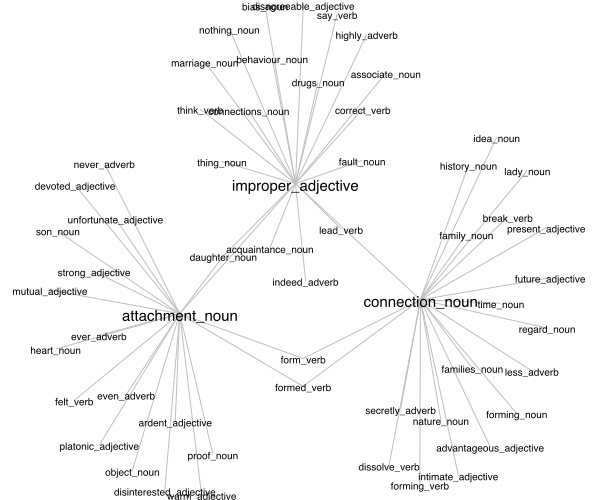

In [146]:
vis_options = {}
vis_options["vertex_shape"] = "hidden"
vis_options["vertex_label"] = assoc_net.vs["name"]
vis_options["vertex_label_dist"] = 0
vis_options["vertex_label_size"] = [label_func(name) for name in assoc_net_untiered.vs["name"]]
vis_options["bbox"] = (0, 0, 600, 500)
vis_options["margin"] = [50,5,50,5]
vis_options["edge_color"] = "grey"
vis_options["layout"] = "kk"
ig.drawing.plot(assoc_net, "figures/figure_3_4.svg", **vis_options)
ig.drawing.plot(assoc_net, **vis_options)